## Classification - all NFL teams

This notebook tests multiple classification models *(Logistic Regression, KNN, Naive Bayes - Gaussian, SVC, Decision Trees, Extra Trees, and Random Forest)* on the entire [dataset of NFL plays](https://www.kaggle.com/maxhorowitz/nflplaybyplay2009to2016) and then determines which features are most important.  Finally, I used [TabPy](https://github.com/tableau/TabPy) to connect to a Tableau server for an interactive visualization.

In [1]:
import psycopg2 as pg
import pandas as pd
import pandas.io.sql as pd_sql
import numpy as np

# visualization imports
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('fivethirtyeight')

%matplotlib inline

# modelling imports
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, accuracy_score, roc_auc_score, roc_curve, precision_recall_curve, f1_score
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler


First, let's get the data in the notebook.  I had created a PostgreSQL database to store the data which you can follow along [here](https://github.com/huangee/nfl_yards_gained/blob/master/00_Create_SQL_Table.ipynb).

In [2]:
# Postgres info to connect

connection_args = {
    'host': 'localhost',
    'dbname': 'nfl_db',
    'port': 5432
}

connection = pg.connect(**connection_args) # Unpacks dictionary keys and values

In [3]:
# create dataframe from selected columns

query = "SELECT play_id, game_date, yards_gained, play_type, posteam, \
        ydsnet, yardline_100, quarter_seconds_remaining, qtr, down, ydstogo \
        FROM nfl_plays \
        WHERE play_type IN ('pass','run');"

df_all = pd_sql.read_sql(query, connection)

Now let's take a look at what the dataframe looks like, and the get it cleaned and ready to pass through some models by creating a train/test split and also a scaled version.

In [4]:
df_all.head()

,play_id,game_date,yards_gained,play_type,posteam,ydsnet,yardline_100,quarter_seconds_remaining,qtr,down,ydstogo
0,68,2009-09-10,5.0,pass,PIT,5,58.0,893.0,1,1.0,10
1,92,2009-09-10,-3.0,run,PIT,2,53.0,856.0,1,2.0,5
2,113,2009-09-10,0.0,pass,PIT,2,56.0,815.0,1,3.0,8
3,162,2009-09-10,0.0,run,TEN,0,98.0,796.0,1,1.0,10
4,183,2009-09-10,4.0,pass,TEN,4,98.0,760.0,1,2.0,10


In [5]:
# create binary for if the play is a pass

df_all['passing'] = df_all['play_type'].apply(lambda x: 1 if x == 'pass' else 0) 
df_all.head()

,play_id,game_date,yards_gained,play_type,posteam,ydsnet,yardline_100,quarter_seconds_remaining,qtr,down,ydstogo,passing
0,68,2009-09-10,5.0,pass,PIT,5,58.0,893.0,1,1.0,10,1
1,92,2009-09-10,-3.0,run,PIT,2,53.0,856.0,1,2.0,5,0
2,113,2009-09-10,0.0,pass,PIT,2,56.0,815.0,1,3.0,8,1
3,162,2009-09-10,0.0,run,TEN,0,98.0,796.0,1,1.0,10,0
4,183,2009-09-10,4.0,pass,TEN,4,98.0,760.0,1,2.0,10,1


In [6]:
# create y for if the yards_gained were positive or not

df_all['yards_g_l'] = df_all['yards_gained'].apply(lambda x: 'gain' if x > 0 else 'loss')
df_all.head()

,play_id,game_date,yards_gained,play_type,posteam,ydsnet,yardline_100,quarter_seconds_remaining,qtr,down,ydstogo,passing,yards_g_l
0,68,2009-09-10,5.0,pass,PIT,5,58.0,893.0,1,1.0,10,1,gain
1,92,2009-09-10,-3.0,run,PIT,2,53.0,856.0,1,2.0,5,0,loss
2,113,2009-09-10,0.0,pass,PIT,2,56.0,815.0,1,3.0,8,1,loss
3,162,2009-09-10,0.0,run,TEN,0,98.0,796.0,1,1.0,10,0,loss
4,183,2009-09-10,4.0,pass,TEN,4,98.0,760.0,1,2.0,10,1,gain


In [7]:
df_all.dropna(inplace=True)
df_all.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 318481 entries, 0 to 319368
Data columns (total 13 columns):
play_id                      318481 non-null int64
game_date                    318481 non-null object
yards_gained                 318481 non-null float64
play_type                    318481 non-null object
posteam                      318481 non-null object
ydsnet                       318481 non-null int64
yardline_100                 318481 non-null float64
quarter_seconds_remaining    318481 non-null float64
qtr                          318481 non-null int64
down                         318481 non-null float64
ydstogo                      318481 non-null int64
passing                      318481 non-null int64
yards_g_l                    318481 non-null object
dtypes: float64(4), int64(5), object(4)
memory usage: 34.0+ MB


In [8]:
df_all.columns

Index(['play_id', 'game_date', 'yards_gained', 'play_type', 'posteam',
       'ydsnet', 'yardline_100', 'quarter_seconds_remaining', 'qtr', 'down',
       'ydstogo', 'passing', 'yards_g_l'],
      dtype='object')

In [9]:
X_train, X_test, y_train, y_test = train_test_split(df_all.iloc[:, 5:12], df_all.iloc[:, 12], 
                                                    test_size = 0.2, random_state=33)

In [10]:
y_test_binary = y_test.apply(lambda x: 1 if x == 'gain' else 0)
y_test_binary.head(10)

22379     1
283482    1
171648    0
214030    1
250360    1
14159     1
317281    0
226150    1
217813    1
3067      1
Name: yards_g_l, dtype: int64

In [11]:
df_all.groupby('yards_g_l').count()
# ratio of yards gain to yards loss is 69.4% to 30.6%
# model needs to have a score better than 69.4% accuracy

,play_id,game_date,yards_gained,play_type,posteam,ydsnet,yardline_100,quarter_seconds_remaining,qtr,down,ydstogo,passing
yards_g_l,,,,,,,,,,,,
gain,211470,211470,211470,211470,211470,211470,211470,211470,211470,211470,211470,211470
loss,107011,107011,107011,107011,107011,107011,107011,107011,107011,107011,107011,107011


In [12]:
std_scale = StandardScaler()

X_train_scaled = std_scale.fit_transform(X_train)
X_test_scaled = std_scale.fit_transform(X_test)

/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda3/lib/python3.7/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda3/lib/python3.7/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


In [13]:
labels = ['loss','gain']

## Logistic Regression

In [14]:
model_lr_scaled = LogisticRegression(random_state = 12)
model_lr_scaled.fit(X_train_scaled, y_train)

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=12, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [15]:
model_lr_scaled.score(X_test_scaled, y_test)

0.7300971788310282

In [16]:
print(classification_report(y_test, model_lr_scaled.predict(X_test_scaled), labels))

              precision    recall  f1-score   support

        loss       0.66      0.41      0.50     21288
        gain       0.75      0.89      0.81     42409

   micro avg       0.73      0.73      0.73     63697
   macro avg       0.70      0.65      0.66     63697
weighted avg       0.72      0.73      0.71     63697



ROC AUC score =  0.7488290122611849


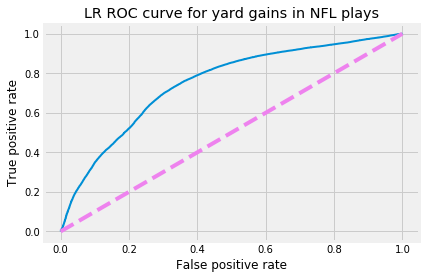

In [17]:
fpr, tpr, thresholds = roc_curve(y_test_binary, model_lr_scaled.predict_proba(X_test_scaled)[:,0])

plt.plot(fpr, tpr,lw=2)
plt.plot([0,1],[0,1],c='violet',ls='--')
plt.xlim([-0.05,1.05])
plt.ylim([-0.05,1.05])

plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('LR ROC curve for yard gains in NFL plays');
print("ROC AUC score = ", roc_auc_score(y_test_binary, model_lr_scaled.predict_proba(X_test_scaled)[:,0]))

## KNN

In [18]:
from sklearn import neighbors
model_knn = neighbors.KNeighborsClassifier()

In [19]:
model_knn.fit(X_train_scaled, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=5, p=2,
           weights='uniform')

In [20]:
model_knn.score(X_test_scaled, y_test)

0.75688022983814

In [21]:
print(classification_report(y_test, model_knn.predict(X_test_scaled), labels))

              precision    recall  f1-score   support

        loss       0.66      0.57      0.61     21288
        gain       0.80      0.85      0.82     42409

   micro avg       0.76      0.76      0.76     63697
   macro avg       0.73      0.71      0.72     63697
weighted avg       0.75      0.76      0.75     63697



ROC AUC score =  0.7841757228415838


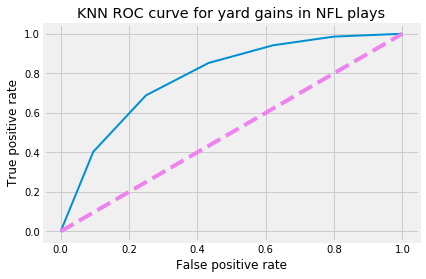

In [22]:
fpr, tpr, thresholds = roc_curve(y_test_binary, model_knn.predict_proba(X_test_scaled)[:,0])

plt.plot(fpr, tpr,lw=2)
plt.plot([0,1],[0,1],c='violet',ls='--')
plt.xlim([-0.05,1.05])
plt.ylim([-0.05,1.05])

plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('KNN ROC curve for yard gains in NFL plays');
print("ROC AUC score = ", roc_auc_score(y_test_binary, model_knn.predict_proba(X_test_scaled)[:,0]))

## SVM

In [23]:
from sklearn.svm import SVC
model_svm = SVC(random_state = 30)

In [24]:
model_svm.fit(X_train_scaled, y_train)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=False, random_state=30,
  shrinking=True, tol=0.001, verbose=False)

In [25]:
model_svm.score(X_test_scaled, y_test)

0.7531594894579022

In [26]:
print(classification_report(y_test, model_svm.predict(X_test_scaled), labels))

              precision    recall  f1-score   support

        loss       0.70      0.47      0.56     21288
        gain       0.77      0.90      0.83     42409

   micro avg       0.75      0.75      0.75     63697
   macro avg       0.73      0.68      0.69     63697
weighted avg       0.74      0.75      0.74     63697



## Naive Bayes - Gaussian

In [27]:
from sklearn import naive_bayes

In [28]:
model_NB_Gaus = naive_bayes.GaussianNB()

In [29]:
model_NB_Gaus.fit(X_train_scaled, y_train)

GaussianNB(priors=None, var_smoothing=1e-09)

In [30]:
model_NB_Gaus.score(X_test_scaled, y_test)

0.7010691241345747

## Decision Tree

In [31]:
from sklearn import tree

In [32]:
model_tree = tree.DecisionTreeClassifier(max_depth=12, random_state=44)

In [33]:
model_tree.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=12,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=44,
            splitter='best')

In [34]:
model_tree.score(X_train, y_train)

0.8246593192665159

In [35]:
model_tree.score(X_test, y_test)

0.8137274910906322

In [36]:
train_score = []
test_score = []

for i in range(1,21):
    model_test = tree.DecisionTreeClassifier(max_depth=i, random_state=44)
    model_test.fit(X_train, y_train)
    train_score.append(model_test.score(X_train, y_train))
    test_score.append(model_test.score(X_test, y_test))

In [37]:
train_score


[0.7283973875910575,
 0.7283973875910575,
 0.731929791509671,
 0.7450350100477267,
 0.7601772481788496,
 0.7690749811605124,
 0.7841230218538056,
 0.7976246546093946,
 0.8059218789248932,
 0.8148156870133132,
 0.8192272670183371,
 0.8246593192665159,
 0.8297656053755338,
 0.8352447563426275,
 0.8419170748555639,
 0.8494253956292389,
 0.8593082768148707,
 0.8693167545842753,
 0.8808206166792263,
 0.8928778887214268]

In [38]:
test_score

[0.7284173508956466,
 0.7284173508956466,
 0.7321066926228865,
 0.7442422720065309,
 0.7605695715653799,
 0.7683878361618287,
 0.7834905882537639,
 0.7943388228644991,
 0.8013407224830055,
 0.8092531830384476,
 0.8113568927892993,
 0.8137274910906322,
 0.8134449032136521,
 0.8114824874012905,
 0.8091589870794543,
 0.8042764965382985,
 0.8009011413410365,
 0.7968821137573198,
 0.7923136097461418,
 0.7866775515330392]

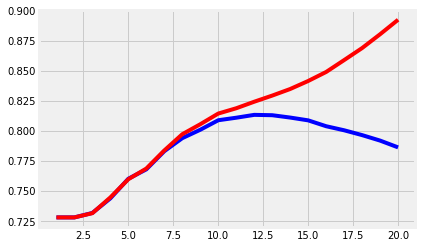

In [39]:
plt.plot(range(1,21), test_score, 'b', range(1,21), train_score, 'r')
plt.show()

# using max_depth of 12 gives best result on test set

In [40]:
print(classification_report(y_test, model_tree.predict(X_test), labels))

              precision    recall  f1-score   support

        loss       0.75      0.67      0.71     21288
        gain       0.84      0.89      0.86     42409

   micro avg       0.81      0.81      0.81     63697
   macro avg       0.79      0.78      0.79     63697
weighted avg       0.81      0.81      0.81     63697



ROC AUC score =  0.858712607968984


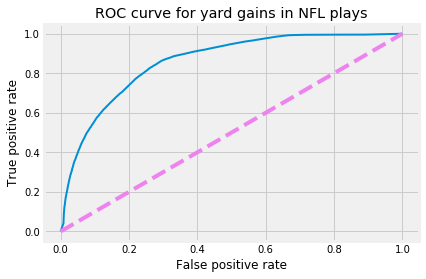

In [41]:
fpr, tpr, thresholds = roc_curve(y_test_binary, model_tree.predict_proba(X_test)[:,0])

plt.plot(fpr, tpr,lw=2)
plt.plot([0,1],[0,1],c='violet',ls='--')
plt.xlim([-0.05,1.05])
plt.ylim([-0.05,1.05])

plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve for yard gains in NFL plays');
print("ROC AUC score = ", roc_auc_score(y_test_binary, model_tree.predict_proba(X_test)[:,0]))

## Extra Trees

In [42]:
from sklearn import ensemble

In [43]:
model_xtrees = ensemble.ExtraTreesClassifier(n_estimators=100, random_state=15)

In [44]:
model_xtrees.fit(X_train, y_train)

ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
           max_depth=None, max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
           oob_score=False, random_state=15, verbose=0, warm_start=False)

In [45]:
model_xtrees.score(X_test, y_test)

0.7910419642997315

In [46]:
print(classification_report(y_test, model_xtrees.predict(X_test), labels))

              precision    recall  f1-score   support

        loss       0.72      0.61      0.66     21288
        gain       0.82      0.88      0.85     42409

   micro avg       0.79      0.79      0.79     63697
   macro avg       0.77      0.74      0.75     63697
weighted avg       0.79      0.79      0.79     63697



ROC AUC score =  0.8352174773735082


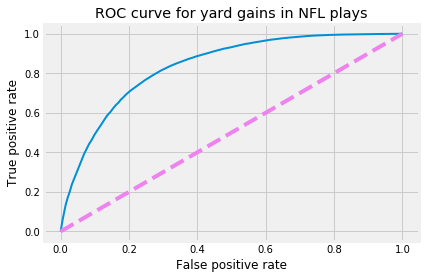

In [47]:
fpr, tpr, thresholds = roc_curve(y_test_binary, model_xtrees.predict_proba(X_test)[:,0])

plt.plot(fpr, tpr,lw=2)
plt.plot([0,1],[0,1],c='violet',ls='--')
plt.xlim([-0.05,1.05])
plt.ylim([-0.05,1.05])

plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve for yard gains in NFL plays');
print("ROC AUC score = ", roc_auc_score(y_test_binary, model_xtrees.predict_proba(X_test)[:,0]))

## Random Forest

In [48]:
model_rf = ensemble.RandomForestClassifier(n_estimators=100, random_state=15)

In [49]:
model_rf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
            oob_score=False, random_state=15, verbose=0, warm_start=False)

In [50]:
model_rf.score(X_test, y_test)

0.8070709766551015

In [51]:
print(classification_report(y_test, model_rf.predict(X_test), labels))

              precision    recall  f1-score   support

        loss       0.75      0.63      0.69     21288
        gain       0.83      0.89      0.86     42409

   micro avg       0.81      0.81      0.81     63697
   macro avg       0.79      0.76      0.77     63697
weighted avg       0.80      0.81      0.80     63697



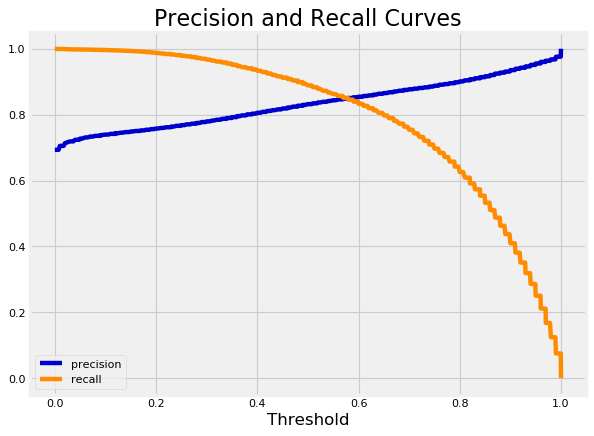

In [52]:
precision_curve, recall_curve, threshold_curve = precision_recall_curve(y_test_binary, model_rf.predict_proba(X_test)[:,0] )

plt.figure(dpi=80, figsize=(8,6))
plt.plot(threshold_curve, precision_curve[1:],label='precision', c='mediumblue')
plt.plot(threshold_curve, recall_curve[1:], label='recall', c='darkorange')
plt.legend(loc='lower left')
plt.xlabel('Threshold',fontsize=15);
plt.title('Precision and Recall Curves',fontsize=20);


In [53]:
threshold = np.linspace(.3,.5,21)
dict_thresholdf1 = dict()

for i in threshold:
    predicted_proba = model_rf.predict_proba(X_test)
    predicted = (predicted_proba [:,0] >= i).astype('int')
    dict_thresholdf1[i] = f1_score(y_test_binary, predicted)

dict_thresholdf1

{0.3: 0.862973883298532,
 0.31: 0.8631570084408613,
 0.32: 0.8635662843988257,
 0.32999999999999996: 0.8638916558930123,
 0.33999999999999997: 0.8644291305087629,
 0.35: 0.8645809984309457,
 0.36: 0.8646140326435255,
 0.37: 0.8648084373654757,
 0.38: 0.8646447627071048,
 0.39: 0.8651754832973729,
 0.4: 0.8648625121056813,
 0.41: 0.8647910406992625,
 0.42: 0.8646312163333371,
 0.43: 0.8643901579011162,
 0.44: 0.8636605009292857,
 0.44999999999999996: 0.8630804944963402,
 0.45999999999999996: 0.8628819986616105,
 0.47: 0.8627661838671015,
 0.48: 0.8621054289378359,
 0.49: 0.8613823343278184,
 0.5: 0.8605060331225808}

In [54]:
maxf1_threshold = max(dict_thresholdf1, key=dict_thresholdf1.get)
maxf1_threshold

0.39

ROC AUC score =  0.8571549261447122


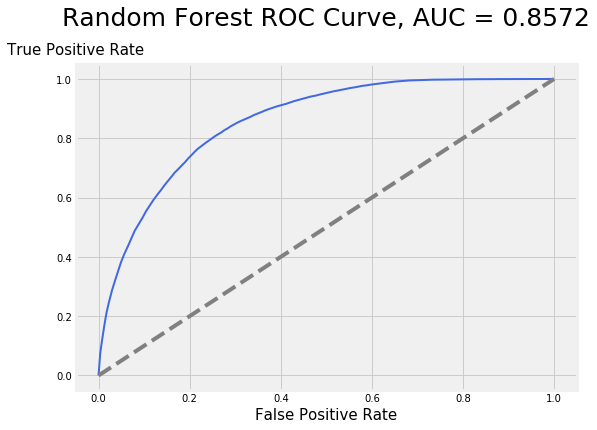

In [55]:
fpr, tpr, thresholds = roc_curve(y_test_binary, model_rf.predict_proba(X_test)[:,0])

plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, lw=2, c='royalblue')
plt.plot([0,1],[0,1],c='gray',ls='--')
plt.xlim([-0.05,1.05])
plt.ylim([-0.05,1.05])

ax = plt.gca()
plt.xlabel('False Positive Rate',fontsize=15)
plt.ylabel('True Positive Rate',fontsize=15,rotation=0)
ax.yaxis.set_label_coords(0.0,1.02)
plt.title('Random Forest ROC Curve, AUC = %.4f'%roc_auc_score(y_test_binary, model_rf.predict_proba(X_test)[:,0]),
          fontsize=25,y=1.1);
print("ROC AUC score = ", roc_auc_score(y_test_binary, model_rf.predict_proba(X_test)[:,0]))

In [56]:
threshold = 0.39

predicted_proba = model_rf.predict_proba(X_test)
predicted = (predicted_proba [:,0] >= threshold).astype('int')

print(classification_report(y_test_binary, predicted))

              precision    recall  f1-score   support

           0       0.82      0.53      0.65     21288
           1       0.80      0.94      0.87     42409

   micro avg       0.80      0.80      0.80     63697
   macro avg       0.81      0.74      0.76     63697
weighted avg       0.81      0.80      0.79     63697



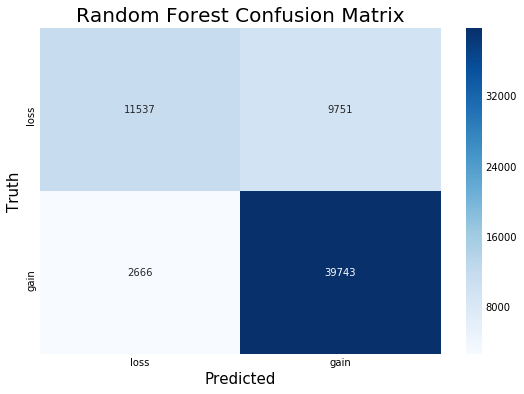

In [57]:
cm_rf = confusion_matrix(y_test, np.where(model_rf.predict_proba(X_test)[:,0] > threshold, 'gain', 'loss'), labels)

fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111)
sns.heatmap(cm_rf, annot=True, fmt='g', cmap="Blues").set_title('Random Forest Confusion Matrix', fontsize=20)
ax.set_xticklabels(labels, fontsize=10)
ax.set_yticklabels(labels, fontsize=10)
plt.xlabel('Predicted', fontsize=15)
plt.ylabel('Truth', fontsize=15);

In [58]:
# columns are ydsnet, yardline_100, quarter_seconds_remaining, qtr, down, ydstogo, passing

model_rf.predict_proba([[78, 60.0, 350.0, 2, 1.0, 10, 0]])

array([[0.94, 0.06]])

In [59]:
# setting a new threshold

rf_predict_probas = model_rf.predict_proba(X_train[:20])
np.where(rf_predict_probas[:,0] > threshold, 'gain', 'loss')

array(['gain', 'gain', 'gain', 'gain', 'loss', 'gain', 'gain', 'gain',
       'gain', 'gain', 'loss', 'gain', 'loss', 'loss', 'gain', 'loss',
       'loss', 'loss', 'loss', 'gain'], dtype='<U4')

In [60]:
# checking if the classes are correct

y_train[:20]

78831     gain
75555     gain
249229    gain
208017    gain
318228    loss
53576     gain
289682    gain
277762    gain
139984    gain
274265    gain
30805     loss
279962    gain
29505     loss
115974    loss
166372    gain
135263    loss
118703    loss
37132     loss
265069    loss
33061     gain
Name: yards_g_l, dtype: object

#### Random Forest - Visualization

In [73]:
from sklearn.tree import export_graphviz
import graphviz

In [128]:
# Export as dot file
export_graphviz(model_tree, out_file='tree.dot', 
                feature_names = X_train.columns,
                class_names = labels,
                max_depth = 3,
                impurity = False, label = 'root',
                rounded = True, proportion = False, 
                precision = 2, filled = True)

In [129]:
# Convert to png using system command (requires Graphviz)
from subprocess import call
call(['dot', '-Tpng', 'tree.dot', '-o', 'tree.png', '-Gdpi=600'])


0

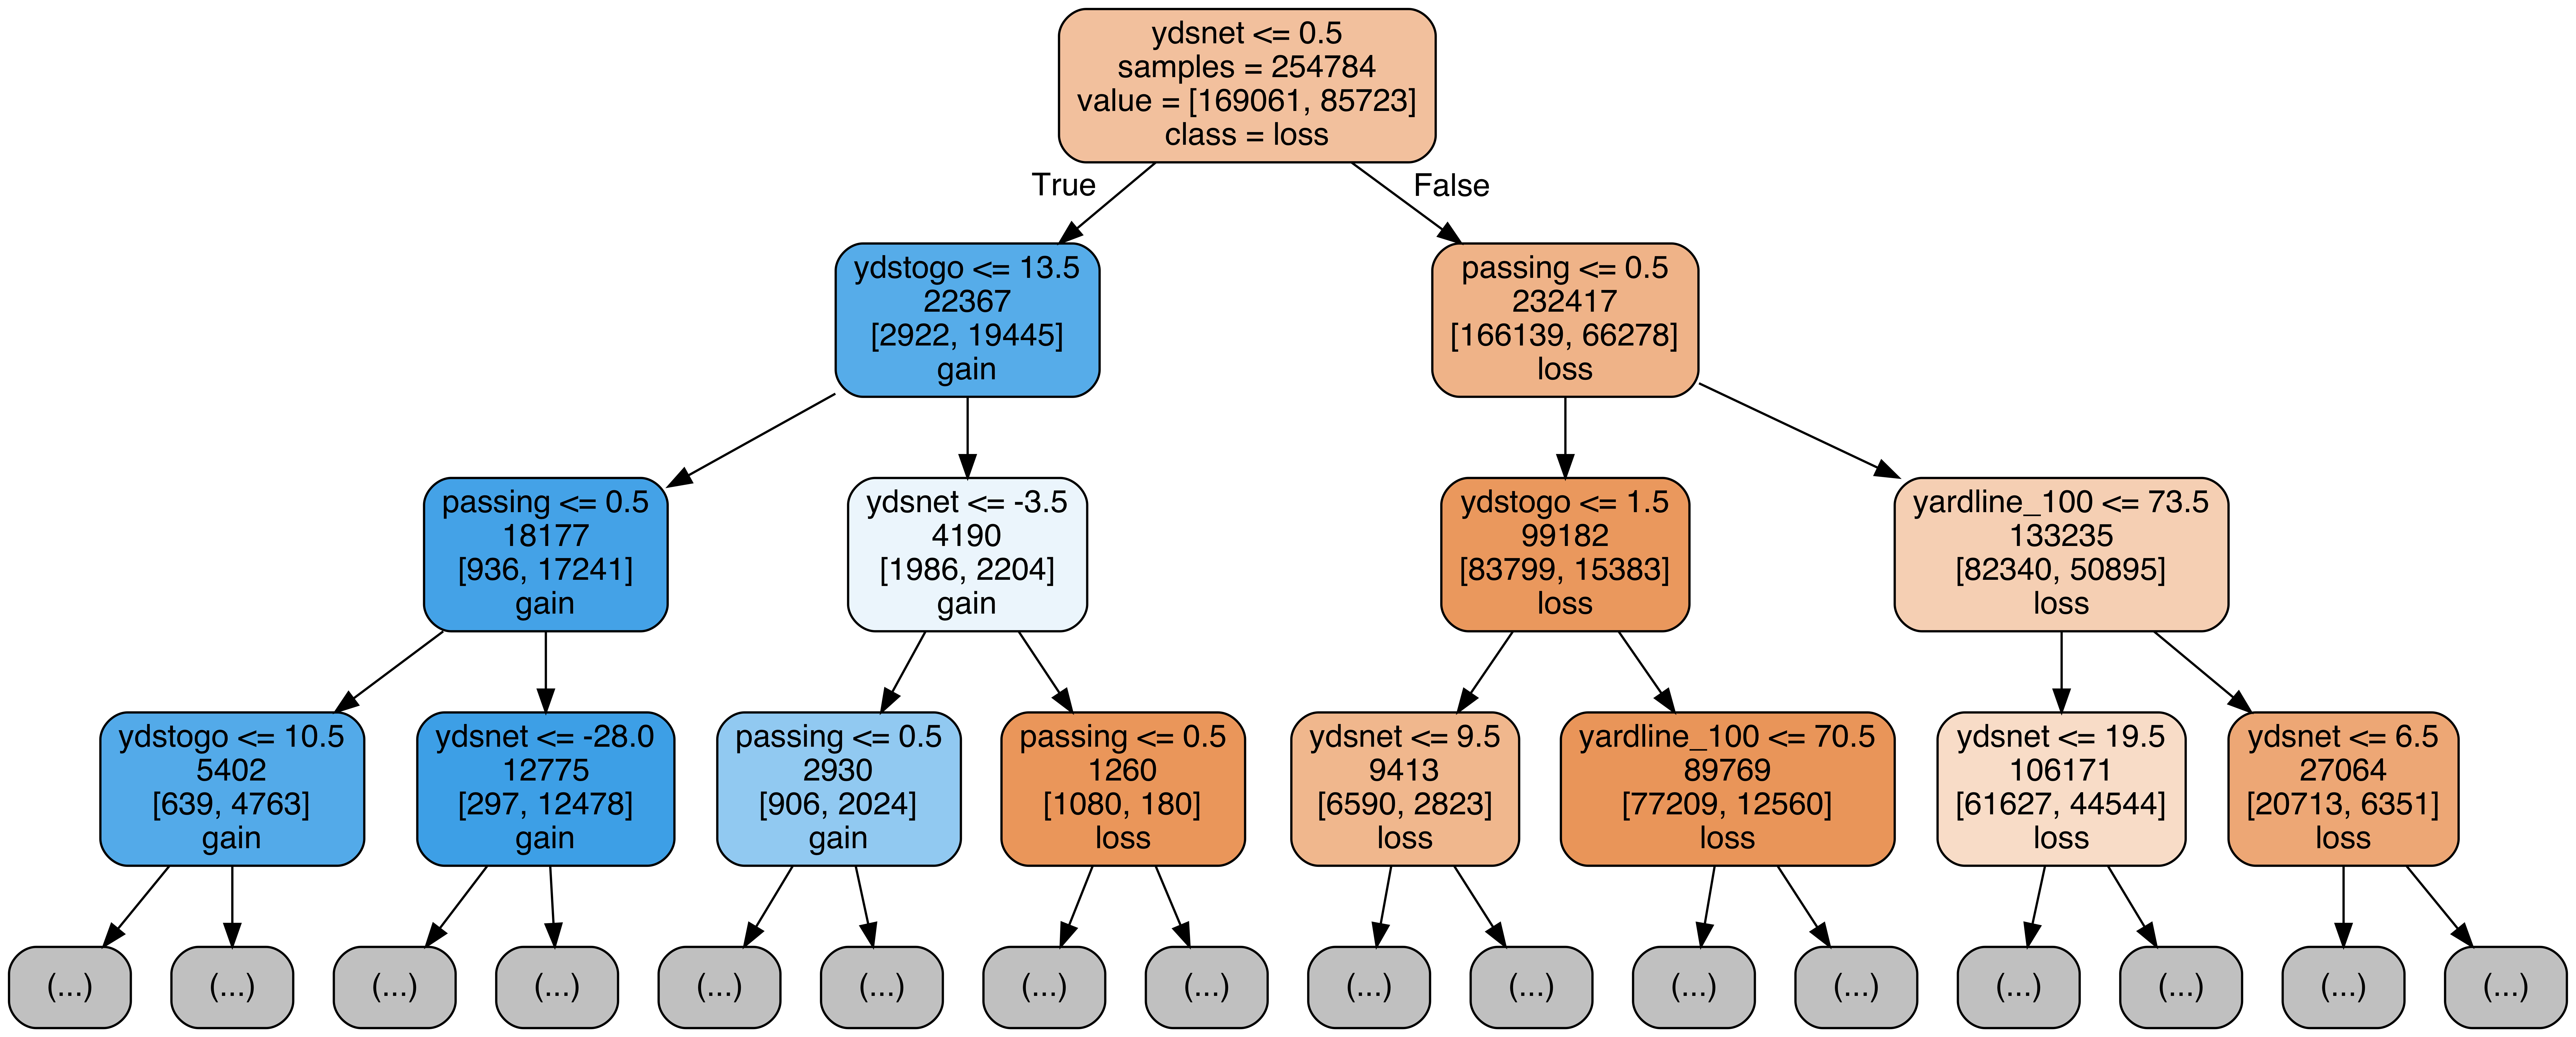

In [130]:
# Display in jupyter notebook
from IPython.display import Image
Image(filename = 'tree.png')

#### Random Forest - Feature Importance - sklearn default

In [90]:
from sklearn.feature_selection import SelectFromModel

In [91]:
sel = SelectFromModel(ensemble.RandomForestClassifier(n_estimators = 100, random_state = 15))
sel.fit(X_train, y_train)
sel.get_support()

array([ True,  True,  True, False, False, False, False])

In [92]:
selected_feat= X_train.columns[(sel.get_support())]
print(selected_feat)

Index(['ydsnet', 'yardline_100', 'quarter_seconds_remaining'], dtype='object')


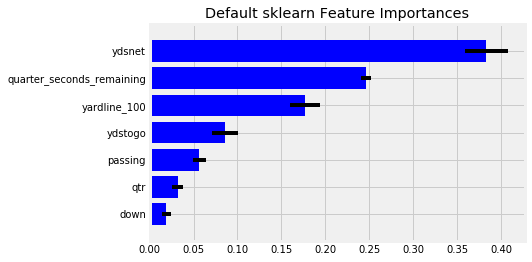

In [93]:
importances = model_rf.feature_importances_
std = np.std([tree.feature_importances_ for tree in model_rf.estimators_],
             axis=0)
indices = np.argsort(importances)

# Plot the feature importances of the forest
plt.figure()
plt.title("Default sklearn Feature Importances")
plt.barh(range(X_train.shape[1]), importances[indices],
       color="b", xerr=std[indices], align="center")
# If you want to define your own labels,
# change indices to a list of labels on the following line.
plt.yticks(range(X_train.shape[1]), [X_train.columns[i] for i in indices])
plt.ylim([-1, X_train.shape[1]])
plt.show()

#### Random Forest - Feature Importance - rfpimp version

https://github.com/parrt/random-forest-importances

In [94]:
from rfpimp import *

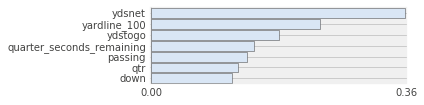

In [95]:
model_rf2 = ensemble.RandomForestClassifier(n_estimators=100, random_state=15)
model_rf2.fit(X_train, y_train)

imp = importances(model_rf2, X_train, y_train) # permutation
viz = plot_importances(imp, width=6)
viz.view()


Top 7 features in both cases are ydsnet, yardline_100, ydstogo, quarter_seconds_remaining, qtr, down, and passing

## Add model to Tableau

In [96]:
import tabpy_client

In [97]:
# Connect to TabPy server using the client library
tab_connection = tabpy_client.Client('http://localhost:9004/')

In [98]:
# Scoring function that will use Random Forest Classifier to classify new data
def GainNoGain(ydsnet, yardline_100, quarter_seconds_remaining, qtr, down, ydstogo, passing):
    X = np.column_stack([ydsnet, yardline_100, quarter_seconds_remaining, qtr, down, ydstogo, passing])
    rf_predict_probas = model_rf.predict_proba(X)
    return np.where(rf_predict_probas[:,0] > threshold, 'gain', 'loss').tolist()

In [99]:
# Testing function return
GainNoGain(20, 50.0, 500.0, 2, 1.0, 10, 1)

['gain']

In [100]:
# Publish the function to TabPy server so it can be used from Tableau
# Using the name NFLYardGains and a short description of what it does

tab_connection.deploy('NFLYardGains', GainNoGain,
                      'Returns if a play will be a yard gain or not based on Random Forest model trained using nflscrapR dataset',
                     override = True)

In [101]:
_arg1 = [1,2,3,4,6,7,8]
_arg2 = [1,2,3,4,6,7,8]
_arg3 = [1,2,3,4,6,7,8]
_arg4 = [1,2,3,4,6,7,8]
_arg5 = [1,2,3,4,6,7,8]
_arg6 = [1,2,3,4,6,7,8]
_arg7 = [1,2,3,4,6,7,8]

In [102]:
tab_connection.query('NFLYardGains', _arg1, _arg2, _arg3, _arg4, _arg5, _arg6, _arg7)

{'response': ['loss', 'loss', 'gain', 'gain', 'loss', 'gain', 'loss'],
 'version': 8,
 'model': 'NFLYardGains',
 'uuid': '9ebaecd2-19a1-41fc-8d96-8eba188c88df'}